# Setup enviorment

In [1]:
from Preprocessing.time_series_preprocessing import get_dengue_dataset, train_test_split, normalize_train_features, normalize_test_features, series_to_supervised, features_labels_set, reshape_tensor

from Models.LSTM import create_model, train_model
import tensorflow as tf

from Utils.test_lstm import evaluate, plot_predictions, calculate_mean_std

import pandas as pd
import os
import numpy as np

In [2]:
""" Read Dataset:"""

embeddings = 'Embeddings/vit_224_1024.csv'
embeddings_dir = 'Embeddings/'

labels = '../Tabular_data/dengue_tabular.csv'

# Get list of municipalities:
Municipalities = list(pd.unique(pd.read_csv('Embeddings/ResNet50V2_224_1024.csv')['Municipality Code']))

""" Dataset Preprocessing:"""
train_percentage = 80
T=3
autoregressive = False
feature_range = (-1, 1)

""" Model Parameters:"""
lstm_layers=[1000, 500]
nn_layers=[250, 120, 1]
dense_acivation='relu'
recurrent_cells='LSTM'
bidirectional=False

## 1. Read Data

In [3]:
# Read dataset for top 5 municipalities
dengue_df = [get_dengue_dataset(labels_path=labels, embeddings_path=embeddings, municipality=Municipality) for Municipality in Municipalities]
type(dengue_df)

Obtaining dataframe for the city of 54001 - Cúcuta only...
Obtaining dataframe for the city of 41001 - Neiva only...
Obtaining dataframe for the city of 5001 - Medellín only...
Obtaining dataframe for the city of 50001 - Villavicencio only...
Obtaining dataframe for the city of 68001 - Bucaramanga only...
Obtaining dataframe for the city of 8001 - Barranquilla only...
Obtaining dataframe for the city of 23001 - Montería only...
Obtaining dataframe for the city of 76001 - Cali only...
Obtaining dataframe for the city of 73001 - Ibagué only...
Obtaining dataframe for the city of 5360 - Itagüí only...


list

### Train Test split

In [4]:
train_df = []
test_df = []

for i in range(len(dengue_df)):
    train_df_aux, test_df_aux = train_test_split(dengue_df[i], train_percentage)
    train_df.append(train_df_aux)
    test_df.append(test_df_aux)
#test_df

The train shape is: (130, 769)
The test shape is: (33, 769)
The train shape is: (130, 769)
The test shape is: (33, 769)
The train shape is: (130, 769)
The test shape is: (33, 769)
The train shape is: (130, 769)
The test shape is: (33, 769)
The train shape is: (130, 769)
The test shape is: (33, 769)
The train shape is: (130, 769)
The test shape is: (33, 769)
The train shape is: (130, 769)
The test shape is: (33, 769)
The train shape is: (130, 769)
The test shape is: (33, 769)
The train shape is: (130, 769)
The test shape is: (33, 769)
The train shape is: (130, 769)
The test shape is: (33, 769)


### Normalize features

In [5]:
# Merge:
train_df = pd.concat([train_df[0], train_df[1], train_df[2], train_df[3], train_df[4]], keys=Municipalities)
test_df = pd.concat([test_df[0], test_df[1], test_df[2], test_df[3], test_df[4]], keys=Municipalities)

In [6]:
# Scale train:
train_df, scalers = normalize_train_features(train_df, feature_range=feature_range)
train_df = [train_df[train_df.index.get_level_values(0) == municipality] for municipality in Municipalities]

#print(f'The scalers are: {scalers}')

train_df[1].head()

0         1         2         3         4         5  \
41001 201546  0.573249 -0.041825 -0.059889 -0.038526 -0.306822  0.107291   
      201547  0.573249 -0.041825 -0.059889 -0.038526 -0.306822  0.107291   
      201548  0.573249 -0.041825 -0.059889 -0.038526 -0.306822  0.107291   
      201549  0.573249 -0.041825 -0.059889 -0.038526 -0.306822  0.107291   
      201550  0.573249 -0.041825 -0.059889 -0.038526 -0.306822  0.107291   

                     6         7         8         9  ...      759      760  \
41001 201546 -0.093779 -0.108233  0.574448 -0.546947  ... -0.79243  0.21285   
      201547 -0.093779 -0.108233  0.574448 -0.546947  ... -0.79243  0.21285   
      201548 -0.093779 -0.108233  0.574448 -0.546947  ... -0.79243  0.21285   
      201549 -0.093779 -0.108233  0.574448 -0.546947  ... -0.79243  0.21285   
      201550 -0.093779 -0.108233  0.574448 -0.546947  ... -0.79243  0.21285   

              761       762       763       764       765       766       767  \
41001 201546  1.0  0.179375  0.514077  0.681041 -0.502136  0.107294  0.015237   
      201547  1.0  0.179375  0.514077  0.681041 -0.502136  0.107294  0.015237   
      201548  1.0  0.179375  0.514077  0.681041 -0.502136  0.107294  0.015237   
      201549  1.0  0.179375  0.514077  0.681041 -0.502136  0.107294  0.015237   
      201550  1.0  0.179375  0.514077  0.681041 -0.502136  0.107294  0.015237   

                Labels  
41001 201546 -0.807107  
      201547 -0.796954  
      201548 -0.800338  
      201549 -0.800338  
      201550 -0.752961  

[5 rows x 769 columns]

In [7]:
# Scale test:
test_df = normalize_test_features(test_df, scalers=scalers)
test_df = [test_df[test_df.index.get_level_values(0) == municipality] for municipality in Municipalities]

test_df[1].head()

0         1         2         3         4         5  \
41001 201820 -0.717980  0.017514  0.024820  0.129907 -0.478811  0.105072   
      201821 -0.007424 -0.531371 -0.407669  0.104465  0.035615  0.068398   
      201822 -0.290351 -0.535512 -0.163314 -0.162400 -0.506500 -0.600458   
      201823 -0.006990  0.172356  0.258581 -0.188547  0.636817  0.164841   
      201824  0.275765 -0.214843 -0.446854  0.365049 -0.358818  0.744816   

                     6         7         8         9  ...       759       760  \
41001 201820  0.452167 -0.604835  0.174617  0.175776  ...  0.748011  0.083175   
      201821  0.378137 -0.880699 -0.205577 -0.100127  ...  0.467853  0.710602   
      201822  0.216423 -0.816322 -0.642712 -0.136582  ...  0.694399  0.191799   
      201823 -0.803981 -0.207784 -0.054057 -0.112157  ... -0.302585 -0.224133   
      201824  0.144693 -0.062994 -0.112604  0.234350  ...  0.407446  0.848582   

                   761       762       763       764       765       766  \
41001 201820 -0.639796  0.032153  0.084160 -0.503296  0.635531 -0.187242   
      201821  0.061519 -0.535752  0.035916  0.227003 -0.125049  0.008214   
      201822  0.133611 -0.393592 -0.151432  0.609279  0.496433 -0.131089   
      201823  0.404389 -0.185394 -0.361200  0.615491  0.528517 -0.249498   
      201824 -0.143377  0.178971  0.150190 -0.449878 -0.420890  0.250170   

                   767    Labels  
41001 201820 -0.131000 -0.932318  
      201821  0.903235 -0.949239  
      201822  0.200336 -0.918782  
      201823 -0.224910 -0.949239  
      201824  0.369932 -0.939086  

[5 rows x 769 columns]

### Prepare data for time series supervised learning (function to create sliding window)

In [8]:
# frame as supervised learning
train = [series_to_supervised(df, n_in=T, autoregressive=autoregressive) for df in train_df]
test = [series_to_supervised(df, n_in=T, autoregressive=autoregressive) for df in test_df]

train[1].shape

(128, 2305)

### Merge train data

In [9]:
# Merge:
train = pd.concat([train[0], train[1], train[2], train[3], train[4]], keys=Municipalities)
test = pd.concat([test[0], test[1], test[2], test[3], test[4]], keys=Municipalities)

In [10]:
train.shape

(640, 2305)

### Features and Labels Set

In [11]:
# Train features and labels set
print('Train:')
train_X, train_y, n_features = features_labels_set(timeseries_data=train, original_df=dengue_df[0], autoregressive=autoregressive)

# Test features and labels set
print('Test:')
test_X, test_y, n_features = features_labels_set(timeseries_data=test, original_df=dengue_df[0], autoregressive=autoregressive)

Train:
The shape of the features is (640, 2304)
The shape of the labels is (640, 1)
Test:
The shape of the features is (155, 2304)
The shape of the labels is (155, 1)


In [12]:
# reshape input to be 3D [samples, timesteps, features]
train_X, test_X = reshape_tensor(train_X, test_X, n_features, T, autoregressive)

The initial shapes are:
The train shape is (640, 2304)
The test shape is (155, 2304)
-----------------------
The Final shapes are:
The train shape is (640, 3, 768)
The test shape is (155, 3, 768)


# 2. Model

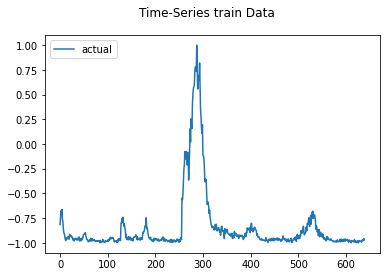

2023-03-04 15:48:45.857967: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-04 15:48:45.858013: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-04 15:48:45.858038: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (9f7bdfccc75e): /proc/driver/nvidia/version does not exist
2023-03-04 15:48:45.858328: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-04 15:48:48.192817: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] 

Restoring model weights from the end of the best epoch.
Epoch 00038: early stopping
Test MAPE: 195.527
Test sMAPE: 78.640
Test RMSE: 40.670
{'mape': 195.52741577664884, 'smape': 78.64016299476108, 'rmse': 40.66955381731305}


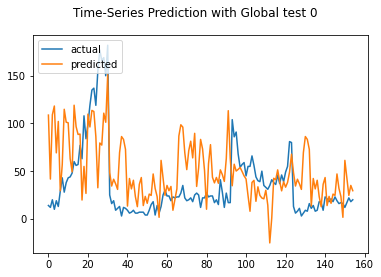

Restoring model weights from the end of the best epoch.
Epoch 00027: early stopping
Test MAPE: 251.291
Test sMAPE: 90.837
Test RMSE: 46.834
{'mape': 251.29125765923655, 'smape': 90.83656989464379, 'rmse': 46.83423884961954}


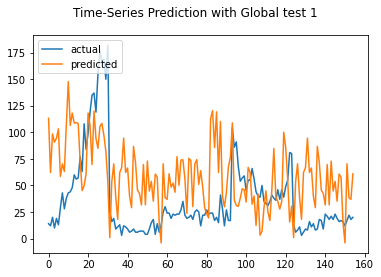

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
Test MAPE: 130.052
Test sMAPE: 85.238
Test RMSE: 38.130
{'mape': 130.05217641959297, 'smape': 85.23846746567477, 'rmse': 38.13016317578844}


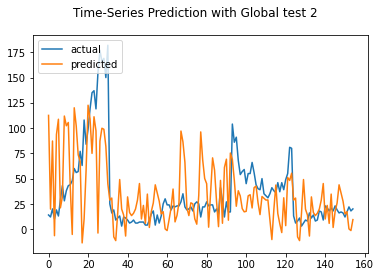

Test MAPE: 229.983
Test sMAPE: 94.919
Test RMSE: 49.108
{'mape': 229.9828145970188, 'smape': 94.91916699845382, 'rmse': 49.108285170167065}


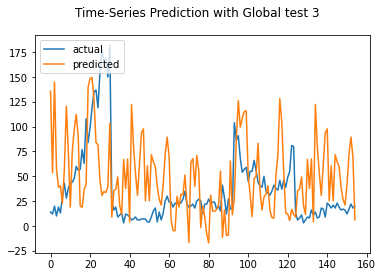

Restoring model weights from the end of the best epoch.
Epoch 00041: early stopping
Test MAPE: 225.387
Test sMAPE: 92.264
Test RMSE: 47.651
{'mape': 225.3873650872774, 'smape': 92.26429451235656, 'rmse': 47.65132580116227}


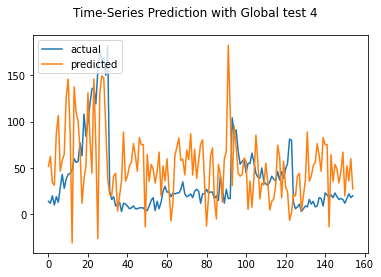

Restoring model weights from the end of the best epoch.
Epoch 00028: early stopping
Test MAPE: 205.904
Test sMAPE: 81.241
Test RMSE: 41.910
{'mape': 205.90350048763463, 'smape': 81.24078995268489, 'rmse': 41.91010993348802}


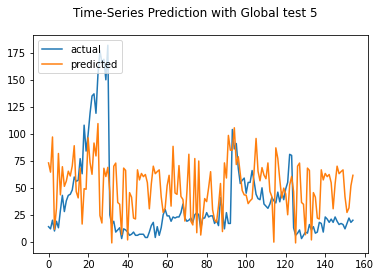

Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping
Test MAPE: 211.830
Test sMAPE: 94.233
Test RMSE: 45.914
{'mape': 211.82991627963318, 'smape': 94.23338871477954, 'rmse': 45.91412634533185}


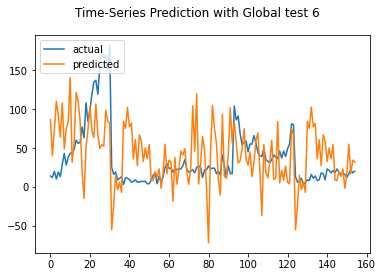

Restoring model weights from the end of the best epoch.
Epoch 00026: early stopping
Test MAPE: 289.446
Test sMAPE: 87.221
Test RMSE: 51.418
{'mape': 289.4458706783876, 'smape': 87.22055020214884, 'rmse': 51.41796277879456}


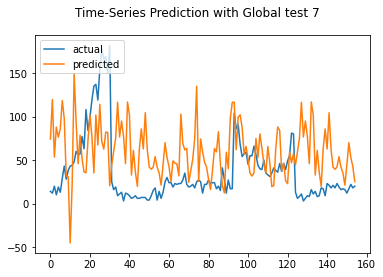

Restoring model weights from the end of the best epoch.
Epoch 00025: early stopping
Test MAPE: 163.913
Test sMAPE: 88.960
Test RMSE: 42.252
{'mape': 163.9130478465064, 'smape': 88.96017767664432, 'rmse': 42.252182530069284}


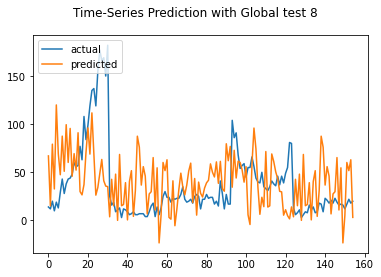

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
Test MAPE: 274.404
Test sMAPE: 90.633
Test RMSE: 48.451
{'mape': 274.40405160765715, 'smape': 90.63347610972707, 'rmse': 48.45081961381188}


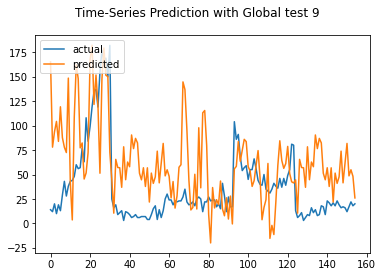

Test MAPE: 184.103
Test sMAPE: 85.915
Test RMSE: 44.827
{'mape': 184.10261818571442, 'smape': 85.91452078078773, 'rmse': 44.82747117507313}


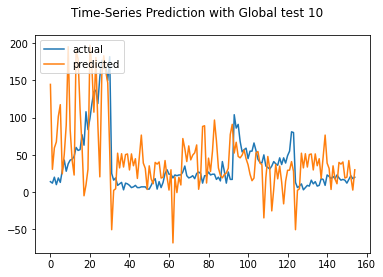

Restoring model weights from the end of the best epoch.
Epoch 00026: early stopping
Test MAPE: 212.739
Test sMAPE: 96.079
Test RMSE: 43.138
{'mape': 212.73868625559857, 'smape': 96.07881313296393, 'rmse': 43.138299999186394}


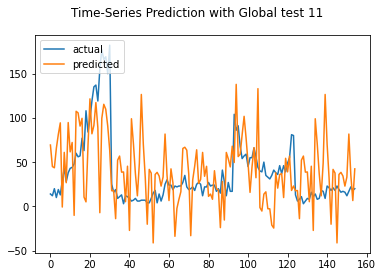

Restoring model weights from the end of the best epoch.
Epoch 00048: early stopping
Test MAPE: 272.780
Test sMAPE: 99.428
Test RMSE: 56.013
{'mape': 272.78007066188775, 'smape': 99.42796701914823, 'rmse': 56.01329244675592}


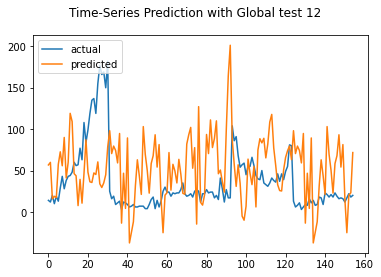

Restoring model weights from the end of the best epoch.
Epoch 00028: early stopping
Test MAPE: 149.722
Test sMAPE: 100.378
Test RMSE: 41.251
{'mape': 149.72185867103306, 'smape': 100.37760970505602, 'rmse': 41.25057197088356}


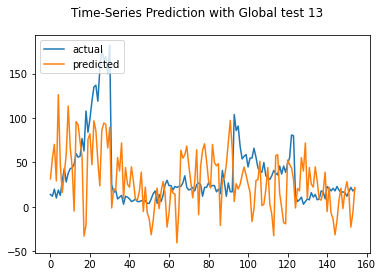

Test MAPE: 359.712
Test sMAPE: 101.067
Test RMSE: 101.715
{'mape': 359.71221095055085, 'smape': 101.0671685201411, 'rmse': 101.71514881195829}


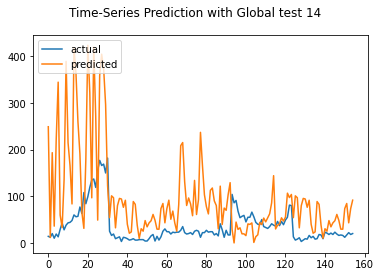

Restoring model weights from the end of the best epoch.
Epoch 00030: early stopping
Test MAPE: 215.141
Test sMAPE: 92.230
Test RMSE: 44.171
{'mape': 215.14106088585584, 'smape': 92.22978440919533, 'rmse': 44.17078416097471}


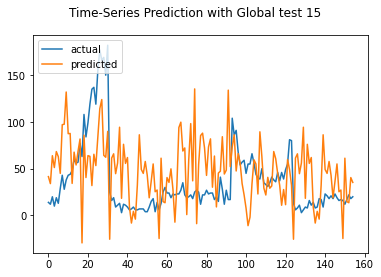

Test MAPE: 208.599
Test sMAPE: 92.328
Test RMSE: 50.802
{'mape': 208.59863553751782, 'smape': 92.32809807851051, 'rmse': 50.80228548106703}


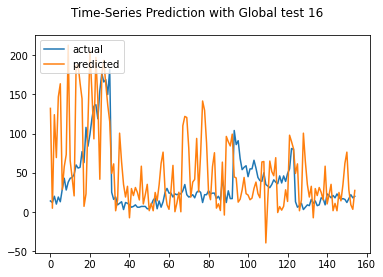

Restoring model weights from the end of the best epoch.
Epoch 00030: early stopping
Test MAPE: 270.546
Test sMAPE: 88.875
Test RMSE: 49.398
{'mape': 270.5463911479893, 'smape': 88.8754503897929, 'rmse': 49.397838885553554}


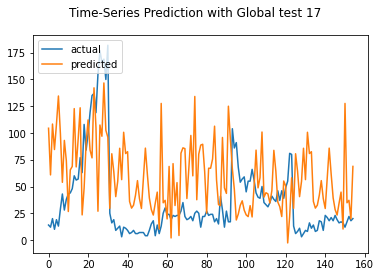

Restoring model weights from the end of the best epoch.
Epoch 00036: early stopping
Test MAPE: 209.243
Test sMAPE: 86.553
Test RMSE: 45.159
{'mape': 209.24303434370205, 'smape': 86.553040285406, 'rmse': 45.159074691390124}


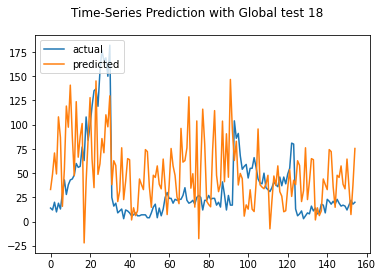

Restoring model weights from the end of the best epoch.
Epoch 00026: early stopping
Test MAPE: 247.858
Test sMAPE: 96.232
Test RMSE: 47.640
{'mape': 247.8575254849763, 'smape': 96.23184903110854, 'rmse': 47.64011624877167}


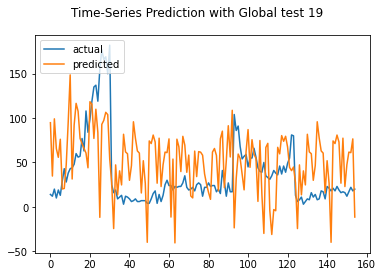

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAPE: 251.002
Test sMAPE: 93.036
Test RMSE: 50.724
{'mape': 251.00242345627382, 'smape': 93.0360849159331, 'rmse': 50.72418088488494}


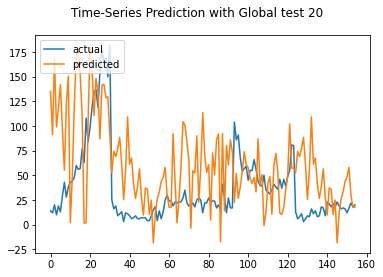

Restoring model weights from the end of the best epoch.
Epoch 00045: early stopping
Test MAPE: 245.828
Test sMAPE: 99.072
Test RMSE: 50.845
{'mape': 245.82837678050757, 'smape': 99.07214157447112, 'rmse': 50.84459455870672}


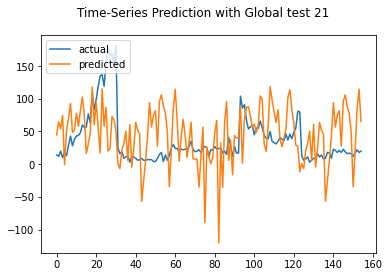

Restoring model weights from the end of the best epoch.
Epoch 00025: early stopping
Test MAPE: 185.617
Test sMAPE: 107.314
Test RMSE: 45.484
{'mape': 185.6174720024924, 'smape': 107.31430226254642, 'rmse': 45.48389267269275}


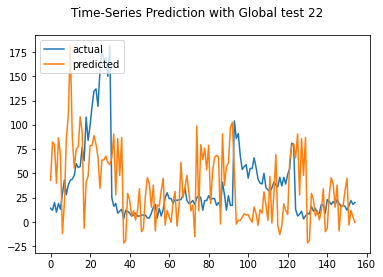

Test MAPE: 177.036
Test sMAPE: 80.598
Test RMSE: 39.052
{'mape': 177.03565269787788, 'smape': 80.5983394285482, 'rmse': 39.05239079654644}


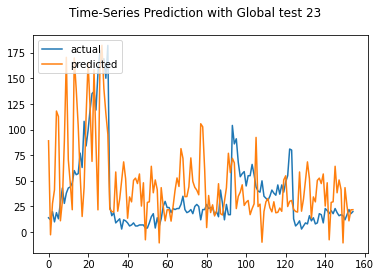

Restoring model weights from the end of the best epoch.
Epoch 00026: early stopping
Test MAPE: 174.968
Test sMAPE: 89.413
Test RMSE: 39.640
{'mape': 174.96774144347478, 'smape': 89.41331787355858, 'rmse': 39.64013363215297}


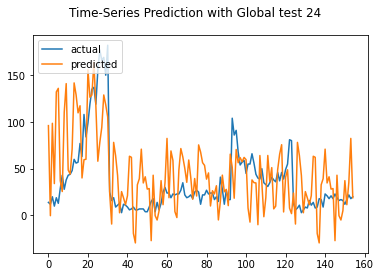

Restoring model weights from the end of the best epoch.
Epoch 00028: early stopping
Test MAPE: 214.714
Test sMAPE: 84.395
Test RMSE: 42.887
{'mape': 214.71414425665802, 'smape': 84.3946912465102, 'rmse': 42.88734444891299}


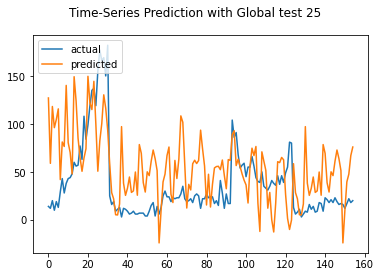

Test MAPE: 347.473
Test sMAPE: 119.723
Test RMSE: 69.961
{'mape': 347.4727589566072, 'smape': 119.72345112205798, 'rmse': 69.96147429459545}


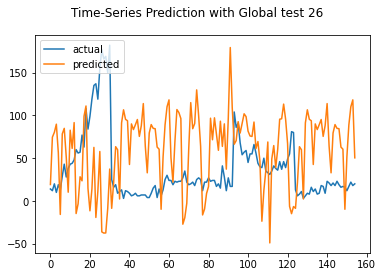

Restoring model weights from the end of the best epoch.
Epoch 00030: early stopping
Test MAPE: 149.926
Test sMAPE: 96.698
Test RMSE: 44.076
{'mape': 149.92647623755877, 'smape': 96.69844098435614, 'rmse': 44.07590178682288}


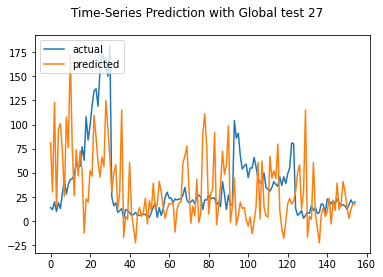

Restoring model weights from the end of the best epoch.
Epoch 00046: early stopping
Test MAPE: 198.122
Test sMAPE: 92.187
Test RMSE: 43.274
{'mape': 198.12246871372392, 'smape': 92.18744648653592, 'rmse': 43.27432784092663}


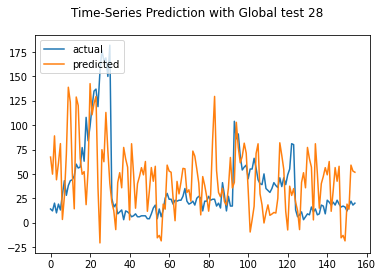

Restoring model weights from the end of the best epoch.
Epoch 00027: early stopping
Test MAPE: 197.487
Test sMAPE: 89.320
Test RMSE: 43.746
{'mape': 197.48734881822537, 'smape': 89.32026765262064, 'rmse': 43.74618099540816}


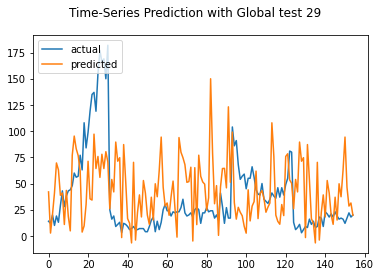

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
Test MAPE: 137.571
Test sMAPE: 80.203
Test RMSE: 44.206
{'mape': 137.57148492202214, 'smape': 80.20288309997193, 'rmse': 44.20640962732871}


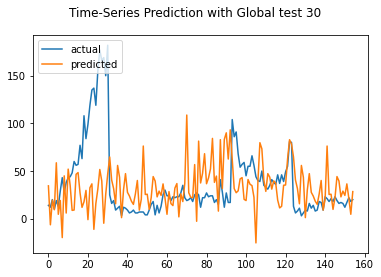

Restoring model weights from the end of the best epoch.
Epoch 00025: early stopping
Test MAPE: 163.034
Test sMAPE: 100.015
Test RMSE: 41.926
{'mape': 163.0339663931264, 'smape': 100.01540532730483, 'rmse': 41.92621023822273}


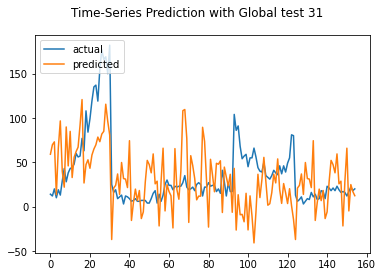

Test MAPE: 188.353
Test sMAPE: 84.815
Test RMSE: 42.086
{'mape': 188.35318639416653, 'smape': 84.8151564122311, 'rmse': 42.08620808710898}


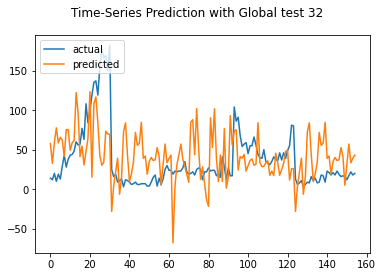

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAPE: 189.566
Test sMAPE: 97.831
Test RMSE: 44.462
{'mape': 189.56608200942244, 'smape': 97.8313422599944, 'rmse': 44.46196297712022}


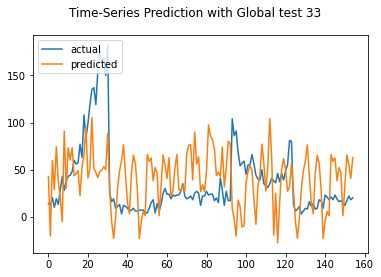

Test MAPE: 290.843
Test sMAPE: 105.337
Test RMSE: 58.730
{'mape': 290.8426307340827, 'smape': 105.33726864014619, 'rmse': 58.73040579863306}


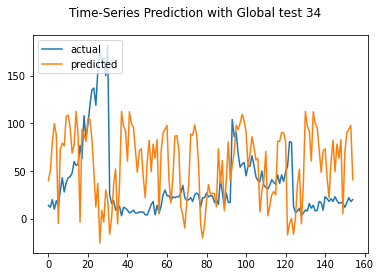

Restoring model weights from the end of the best epoch.
Epoch 00046: early stopping
Test MAPE: 187.350
Test sMAPE: 91.380
Test RMSE: 42.289
{'mape': 187.3502629196375, 'smape': 91.38044080389284, 'rmse': 42.28911119843511}


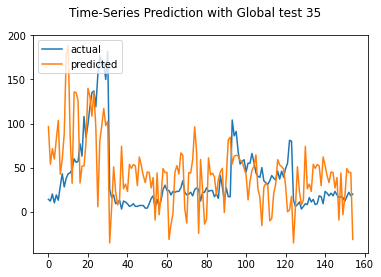

Test MAPE: 291.081
Test sMAPE: 85.206
Test RMSE: 77.269
{'mape': 291.0814250499593, 'smape': 85.20571648921135, 'rmse': 77.26888008235825}


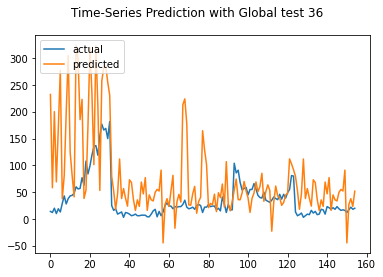

Restoring model weights from the end of the best epoch.
Epoch 00041: early stopping
Test MAPE: 171.874
Test sMAPE: 92.623
Test RMSE: 41.917
{'mape': 171.87428101477857, 'smape': 92.62264790411601, 'rmse': 41.91725620570309}


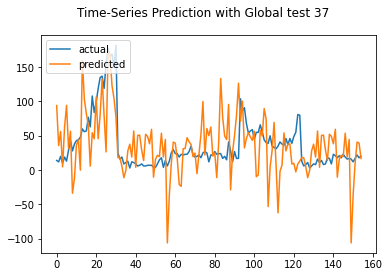

Restoring model weights from the end of the best epoch.
Epoch 00026: early stopping
Test MAPE: 217.842
Test sMAPE: 85.159
Test RMSE: 44.997
{'mape': 217.8424761047869, 'smape': 85.15911873633546, 'rmse': 44.99735647120898}


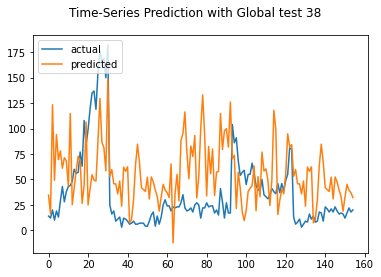

Restoring model weights from the end of the best epoch.
Epoch 00027: early stopping
Test MAPE: 221.776
Test sMAPE: 86.549
Test RMSE: 47.519
{'mape': 221.77586969608893, 'smape': 86.54870299650264, 'rmse': 47.5194302083815}


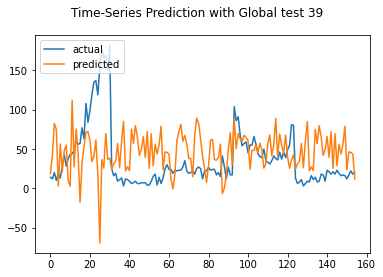

Restoring model weights from the end of the best epoch.
Epoch 00026: early stopping
Test MAPE: 169.254
Test sMAPE: 106.113
Test RMSE: 42.432
{'mape': 169.25359048008607, 'smape': 106.11292500354361, 'rmse': 42.43205803750427}


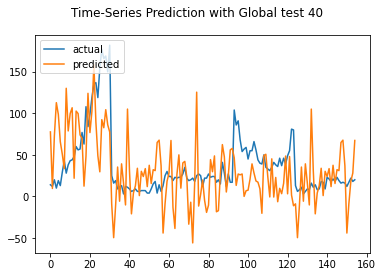

Restoring model weights from the end of the best epoch.
Epoch 00040: early stopping
Test MAPE: 208.050
Test sMAPE: 86.322
Test RMSE: 43.443
{'mape': 208.0495733259893, 'smape': 86.3220836376433, 'rmse': 43.44318785285948}


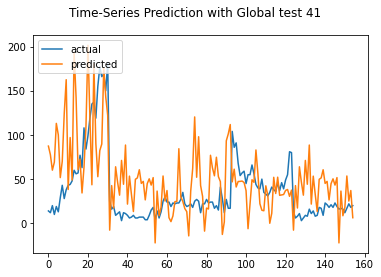

Restoring model weights from the end of the best epoch.
Epoch 00038: early stopping
Test MAPE: 215.692
Test sMAPE: 91.492
Test RMSE: 44.799
{'mape': 215.69240128533588, 'smape': 91.49235618795677, 'rmse': 44.79948303671592}


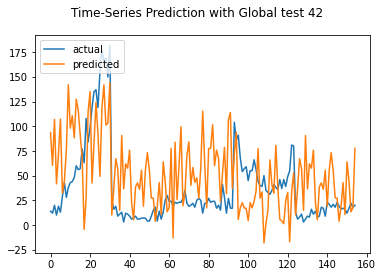

Restoring model weights from the end of the best epoch.
Epoch 00025: early stopping
Test MAPE: 123.240
Test sMAPE: 93.176
Test RMSE: 41.714
{'mape': 123.24017888581974, 'smape': 93.17648205450318, 'rmse': 41.71408177741287}


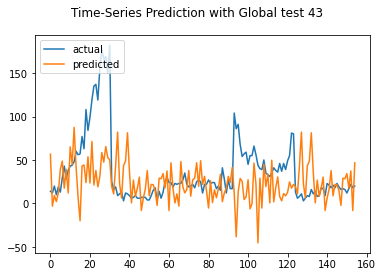

Restoring model weights from the end of the best epoch.
Epoch 00027: early stopping
Test MAPE: 247.341
Test sMAPE: 83.520
Test RMSE: 47.550
{'mape': 247.3411154632077, 'smape': 83.52018586555289, 'rmse': 47.550370035283606}


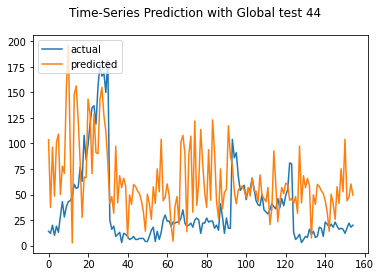

Restoring model weights from the end of the best epoch.
Epoch 00028: early stopping
Test MAPE: 223.937
Test sMAPE: 117.704
Test RMSE: 45.755
{'mape': 223.9369923244236, 'smape': 117.703898451811, 'rmse': 45.755109964094856}


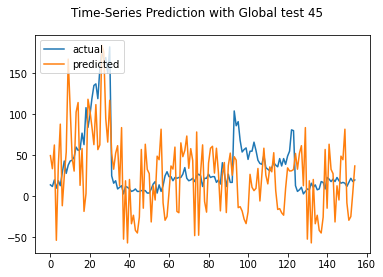

Restoring model weights from the end of the best epoch.
Epoch 00028: early stopping
Test MAPE: 208.454
Test sMAPE: 110.894
Test RMSE: 53.571
{'mape': 208.45443201600676, 'smape': 110.8941451450607, 'rmse': 53.57078840901278}


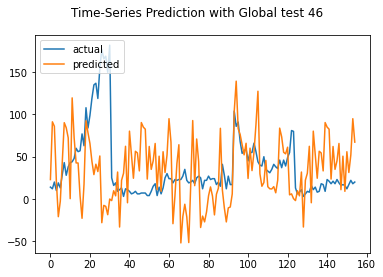

Restoring model weights from the end of the best epoch.
Epoch 00029: early stopping
Test MAPE: 212.183
Test sMAPE: 99.505
Test RMSE: 52.863
{'mape': 212.1825078611079, 'smape': 99.50519507128479, 'rmse': 52.86336523555737}


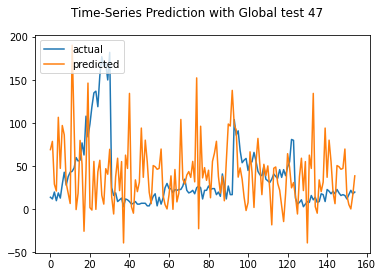

Restoring model weights from the end of the best epoch.
Epoch 00028: early stopping
Test MAPE: 151.648
Test sMAPE: 110.860
Test RMSE: 50.221
{'mape': 151.6481341602847, 'smape': 110.85996331167813, 'rmse': 50.22138655920181}


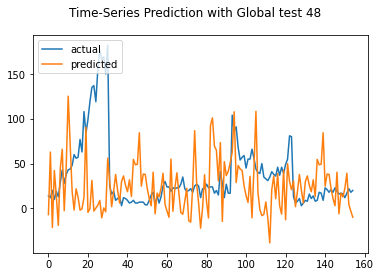

Restoring model weights from the end of the best epoch.
Epoch 00025: early stopping
Test MAPE: 249.469
Test sMAPE: 87.030
Test RMSE: 43.331
{'mape': 249.4690989786431, 'smape': 87.03025075233204, 'rmse': 43.330792785201005}


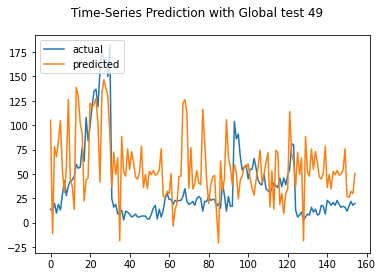

Restoring model weights from the end of the best epoch.
Epoch 00044: early stopping
Test MAPE: 204.068
Test sMAPE: 83.584
Test RMSE: 43.154
{'mape': 204.0677450344227, 'smape': 83.58440824635565, 'rmse': 43.15377499944324}


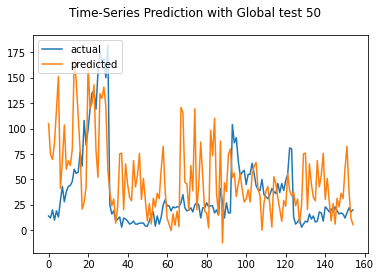

Test MAPE: 328.119
Test sMAPE: 99.389
Test RMSE: 59.322
{'mape': 328.11935436620286, 'smape': 99.38916909369176, 'rmse': 59.32187924295219}


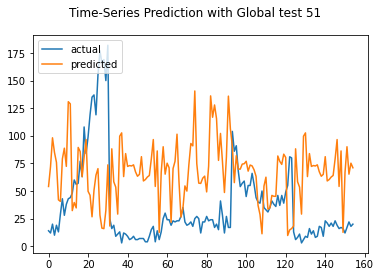

Restoring model weights from the end of the best epoch.
Epoch 00027: early stopping
Test MAPE: 218.420
Test sMAPE: 102.889
Test RMSE: 50.703
{'mape': 218.42037297857235, 'smape': 102.88948813292673, 'rmse': 50.7033997267219}


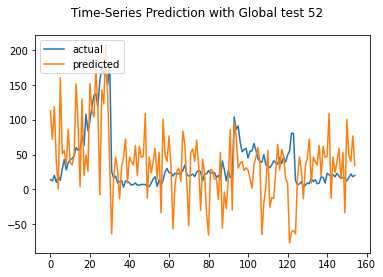

Restoring model weights from the end of the best epoch.
Epoch 00027: early stopping
Test MAPE: 214.987
Test sMAPE: 85.861
Test RMSE: 44.358
{'mape': 214.98709540861887, 'smape': 85.86138401801243, 'rmse': 44.35755026399819}


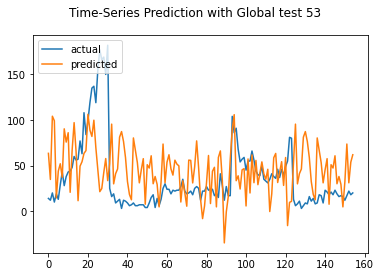

Test MAPE: 485.907
Test sMAPE: 128.673
Test RMSE: 115.489
{'mape': 485.90657716676134, 'smape': 128.67330210367578, 'rmse': 115.48919809365678}


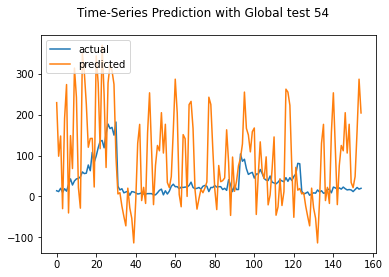

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
Test MAPE: 211.465
Test sMAPE: 89.106
Test RMSE: 45.156
{'mape': 211.46530023595568, 'smape': 89.10561662129031, 'rmse': 45.155748810582004}


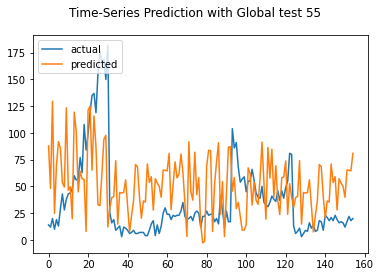

Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Test MAPE: 269.186
Test sMAPE: 85.821
Test RMSE: 47.535
{'mape': 269.1861703559998, 'smape': 85.821276366279, 'rmse': 47.534885168419805}


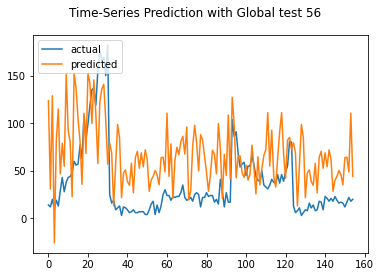

Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Test MAPE: 125.259
Test sMAPE: 87.540
Test RMSE: 35.100
{'mape': 125.25931471972318, 'smape': 87.54008271225739, 'rmse': 35.100123848731826}


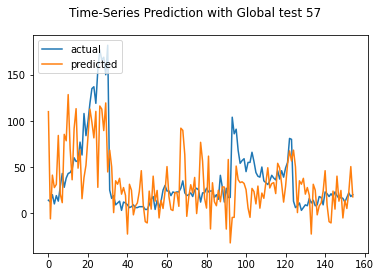

Restoring model weights from the end of the best epoch.
Epoch 00026: early stopping
Test MAPE: 178.893
Test sMAPE: 82.452
Test RMSE: 39.737
{'mape': 178.89289927615056, 'smape': 82.45189754777896, 'rmse': 39.73694193341397}


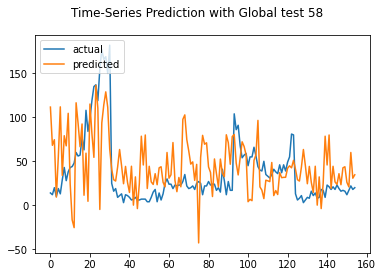

Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Test MAPE: 174.009
Test sMAPE: 95.620
Test RMSE: 40.161
{'mape': 174.00875795708234, 'smape': 95.62029206659601, 'rmse': 40.16051430732208}


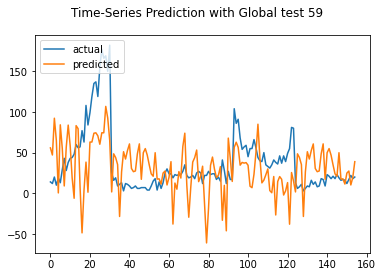

Restoring model weights from the end of the best epoch.
Epoch 00030: early stopping
Test MAPE: 205.995
Test sMAPE: 96.574
Test RMSE: 46.284
{'mape': 205.99484067505372, 'smape': 96.57384969371294, 'rmse': 46.28401159943849}


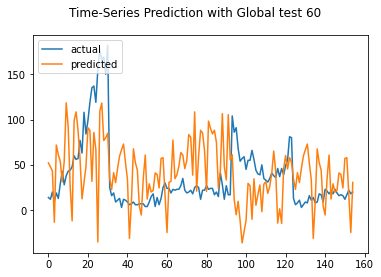

Restoring model weights from the end of the best epoch.
Epoch 00025: early stopping
Test MAPE: 227.023
Test sMAPE: 87.714
Test RMSE: 42.235
{'mape': 227.02285046513282, 'smape': 87.71392782230716, 'rmse': 42.2350599033691}


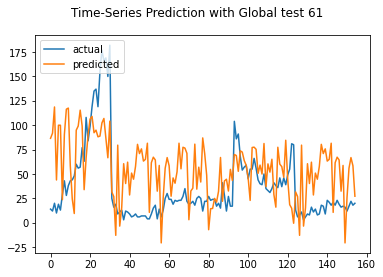

Restoring model weights from the end of the best epoch.
Epoch 00029: early stopping
Test MAPE: 190.663
Test sMAPE: 76.906
Test RMSE: 43.034
{'mape': 190.66281094746972, 'smape': 76.90628011793042, 'rmse': 43.03366508445534}


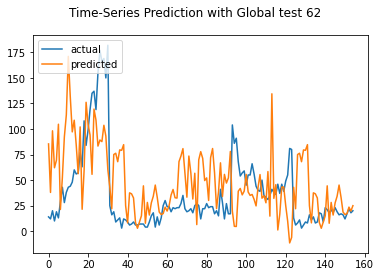

Restoring model weights from the end of the best epoch.
Epoch 00027: early stopping
Test MAPE: 243.243
Test sMAPE: 86.473
Test RMSE: 41.453
{'mape': 243.24341047173667, 'smape': 86.47258585825632, 'rmse': 41.453264642264415}


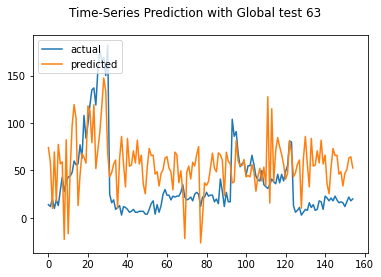

Restoring model weights from the end of the best epoch.
Epoch 00027: early stopping
Test MAPE: 216.517
Test sMAPE: 87.777
Test RMSE: 49.454
{'mape': 216.51669289460452, 'smape': 87.77700087897298, 'rmse': 49.45391926715089}


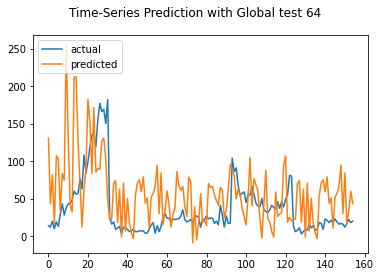

Restoring model weights from the end of the best epoch.
Epoch 00036: early stopping
Test MAPE: 161.435
Test sMAPE: 107.811
Test RMSE: 40.758
{'mape': 161.43502450119774, 'smape': 107.81057045199289, 'rmse': 40.757695743171645}


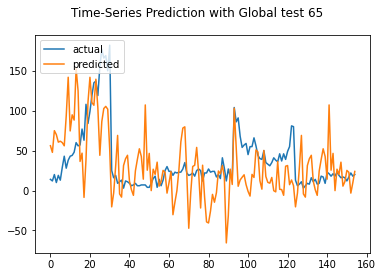

Restoring model weights from the end of the best epoch.
Epoch 00026: early stopping
Test MAPE: 166.060
Test sMAPE: 120.064
Test RMSE: 51.811
{'mape': 166.05995495781386, 'smape': 120.06432652392878, 'rmse': 51.81065938441777}


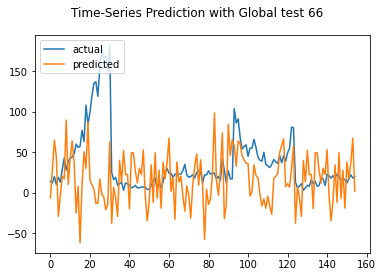

Test MAPE: 322.737
Test sMAPE: 93.700
Test RMSE: 58.693
{'mape': 322.73690285868827, 'smape': 93.70041313727378, 'rmse': 58.693467753844715}


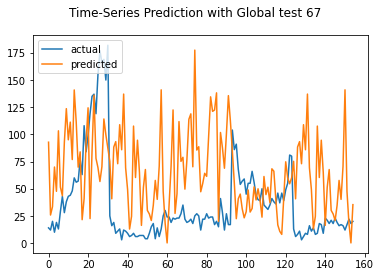

Restoring model weights from the end of the best epoch.
Epoch 00028: early stopping
Test MAPE: 181.177
Test sMAPE: 127.801
Test RMSE: 47.491
{'mape': 181.17739868958748, 'smape': 127.80142565312863, 'rmse': 47.49131325229031}


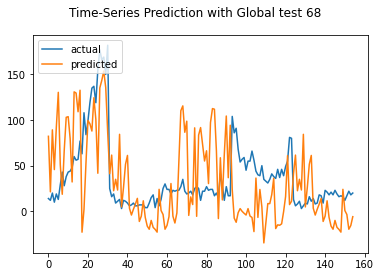

Restoring model weights from the end of the best epoch.
Epoch 00027: early stopping
Test MAPE: 207.488
Test sMAPE: 84.924
Test RMSE: 41.459
{'mape': 207.48791244236773, 'smape': 84.92378510361114, 'rmse': 41.458515376592466}


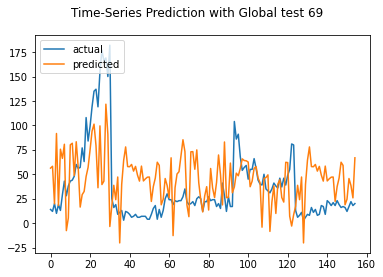

Restoring model weights from the end of the best epoch.
Epoch 00044: early stopping
Test MAPE: 234.467
Test sMAPE: 94.158
Test RMSE: 48.747
{'mape': 234.46667158398475, 'smape': 94.1575835529633, 'rmse': 48.74699833148829}


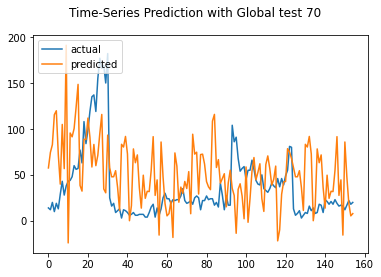

Restoring model weights from the end of the best epoch.
Epoch 00026: early stopping
Test MAPE: 213.247
Test sMAPE: 104.342
Test RMSE: 47.697
{'mape': 213.24715773348282, 'smape': 104.34154212005421, 'rmse': 47.69694739359618}


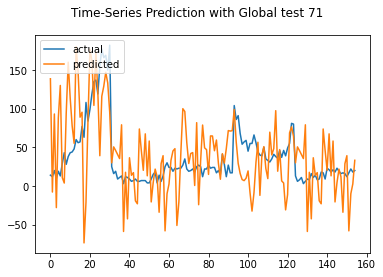

Restoring model weights from the end of the best epoch.
Epoch 00025: early stopping
Test MAPE: 154.275
Test sMAPE: 132.095
Test RMSE: 50.601
{'mape': 154.27452608314283, 'smape': 132.09468062808298, 'rmse': 50.601272386166755}


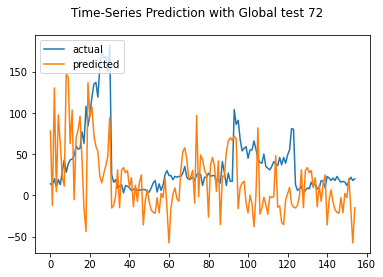

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
Test MAPE: 205.092
Test sMAPE: 86.743
Test RMSE: 45.884
{'mape': 205.09172896653553, 'smape': 86.74272606885773, 'rmse': 45.884026853740146}


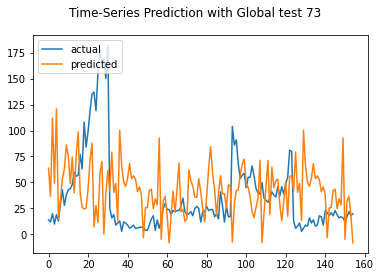

Restoring model weights from the end of the best epoch.
Epoch 00027: early stopping
Test MAPE: 214.867
Test sMAPE: 88.664
Test RMSE: 48.132
{'mape': 214.86733067651124, 'smape': 88.66377988426012, 'rmse': 48.132015731399505}


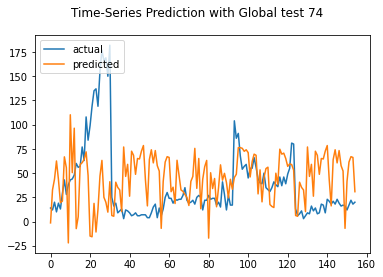

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
Test MAPE: 170.483
Test sMAPE: 127.561
Test RMSE: 53.632
{'mape': 170.4828331934119, 'smape': 127.56096320672289, 'rmse': 53.63244614622427}


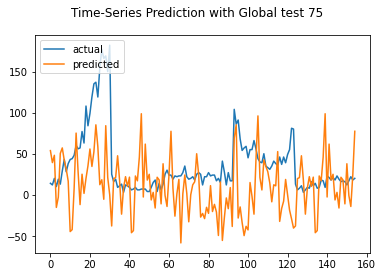

Restoring model weights from the end of the best epoch.
Epoch 00026: early stopping
Test MAPE: 170.194
Test sMAPE: 132.224
Test RMSE: 48.964
{'mape': 170.19411494401362, 'smape': 132.22442901800875, 'rmse': 48.963880224662084}


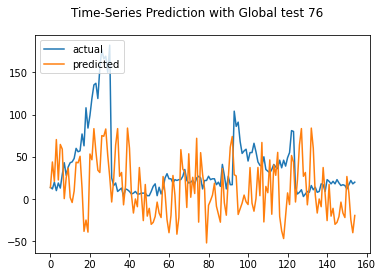

Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Test MAPE: 184.027
Test sMAPE: 95.873
Test RMSE: 43.571
{'mape': 184.02746337878256, 'smape': 95.8734443342487, 'rmse': 43.571211968682704}


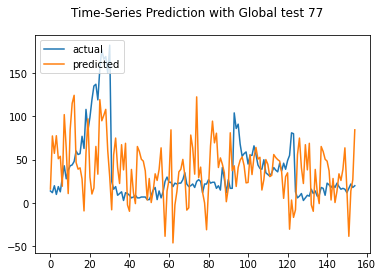

Restoring model weights from the end of the best epoch.
Epoch 00027: early stopping
Test MAPE: 195.703
Test sMAPE: 94.896
Test RMSE: 45.288
{'mape': 195.7030054582225, 'smape': 94.89550538859069, 'rmse': 45.288040051570846}


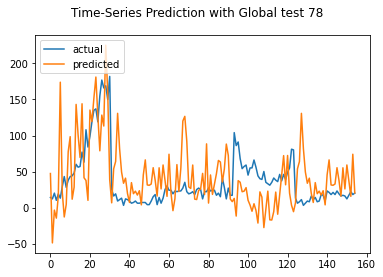

Restoring model weights from the end of the best epoch.
Epoch 00025: early stopping
Test MAPE: 183.430
Test sMAPE: 98.218
Test RMSE: 45.024
{'mape': 183.42964949740667, 'smape': 98.21825499388571, 'rmse': 45.02405000440798}


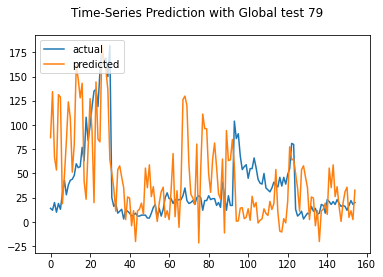

Restoring model weights from the end of the best epoch.
Epoch 00028: early stopping
Test MAPE: 189.030
Test sMAPE: 120.908
Test RMSE: 47.559
{'mape': 189.0304669844467, 'smape': 120.907636407815, 'rmse': 47.55893381131194}


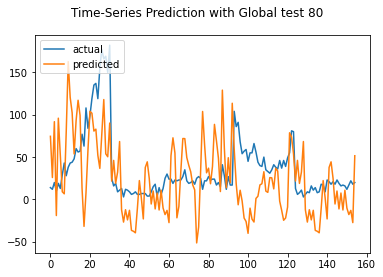

Restoring model weights from the end of the best epoch.
Epoch 00034: early stopping
Test MAPE: 154.669
Test sMAPE: 81.286
Test RMSE: 38.925
{'mape': 154.66888493560458, 'smape': 81.28610920977147, 'rmse': 38.92532478171416}


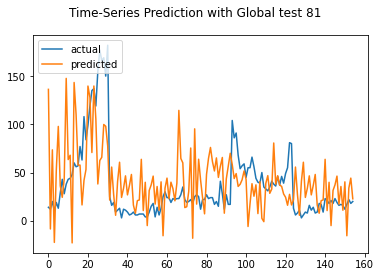

Restoring model weights from the end of the best epoch.
Epoch 00028: early stopping
Test MAPE: 252.809
Test sMAPE: 89.609
Test RMSE: 47.904
{'mape': 252.8090110800446, 'smape': 89.60861099734367, 'rmse': 47.90369958599095}


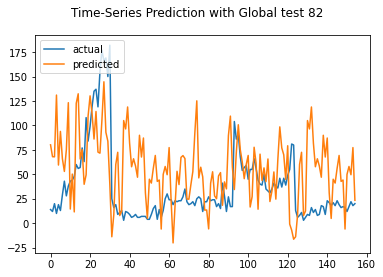

Restoring model weights from the end of the best epoch.
Epoch 00030: early stopping
Test MAPE: 165.508
Test sMAPE: 89.380
Test RMSE: 40.148
{'mape': 165.50824858116752, 'smape': 89.38042106591175, 'rmse': 40.14807626471749}


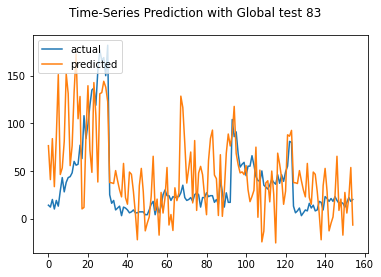

Restoring model weights from the end of the best epoch.
Epoch 00045: early stopping
Test MAPE: 148.058
Test sMAPE: 93.796
Test RMSE: 42.106
{'mape': 148.05758933439503, 'smape': 93.7956946203289, 'rmse': 42.10608812884892}


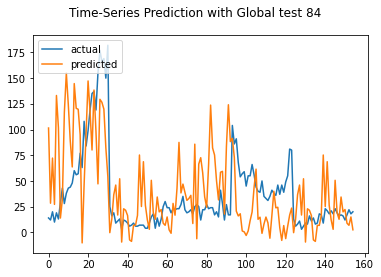

Restoring model weights from the end of the best epoch.
Epoch 00027: early stopping
Test MAPE: 267.502
Test sMAPE: 96.193
Test RMSE: 49.490
{'mape': 267.50213223517227, 'smape': 96.19307064486975, 'rmse': 49.48995601721046}


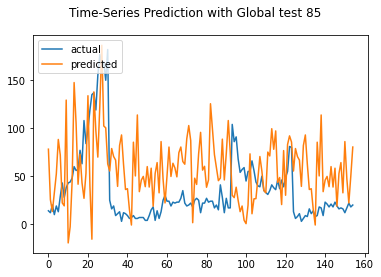

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
Test MAPE: 275.666
Test sMAPE: 87.542
Test RMSE: 45.951
{'mape': 275.6662438703272, 'smape': 87.54246845496236, 'rmse': 45.9509644455394}


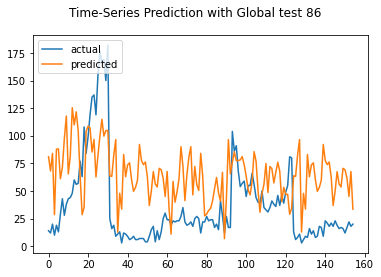

Restoring model weights from the end of the best epoch.
Epoch 00027: early stopping
Test MAPE: 166.917
Test sMAPE: 94.732
Test RMSE: 42.530
{'mape': 166.9174530465517, 'smape': 94.7324268646632, 'rmse': 42.53035165759489}


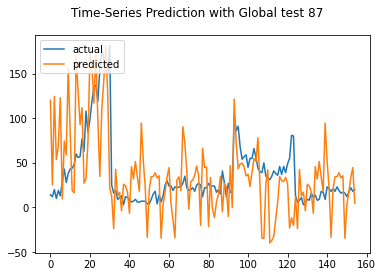

Restoring model weights from the end of the best epoch.
Epoch 00034: early stopping
Test MAPE: 285.222
Test sMAPE: 98.624
Test RMSE: 54.644
{'mape': 285.22226217850164, 'smape': 98.62448617869116, 'rmse': 54.64405240990407}


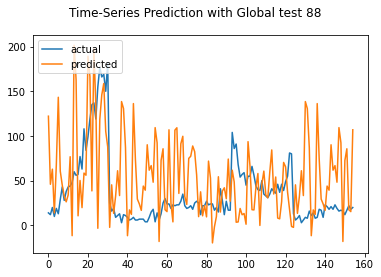

Restoring model weights from the end of the best epoch.
Epoch 00028: early stopping
Test MAPE: 164.822
Test sMAPE: 84.678
Test RMSE: 40.435
{'mape': 164.82204122507972, 'smape': 84.67799910327142, 'rmse': 40.43541979454488}


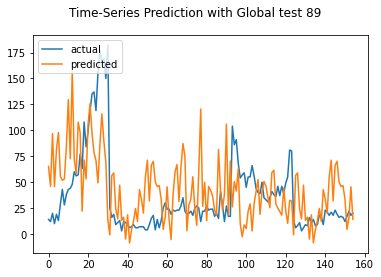

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
Test MAPE: 284.349
Test sMAPE: 90.386
Test RMSE: 50.472
{'mape': 284.34855151625214, 'smape': 90.38631692675429, 'rmse': 50.47246996658428}


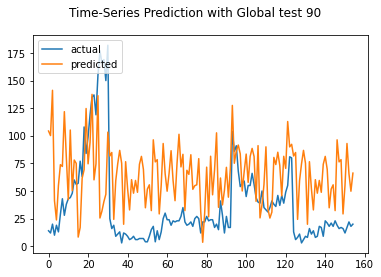

Restoring model weights from the end of the best epoch.
Epoch 00046: early stopping
Test MAPE: 206.687
Test sMAPE: 90.659
Test RMSE: 47.531
{'mape': 206.68653441982352, 'smape': 90.65912338515214, 'rmse': 47.53108728753836}


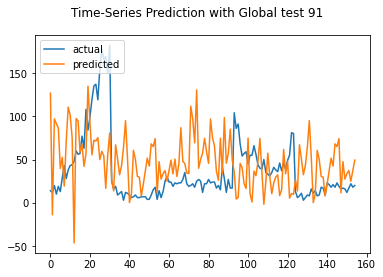

Restoring model weights from the end of the best epoch.
Epoch 00029: early stopping
Test MAPE: 189.974
Test sMAPE: 78.878
Test RMSE: 41.716
{'mape': 189.97392956633084, 'smape': 78.87815931564468, 'rmse': 41.715755197912564}


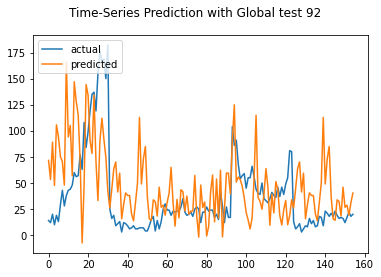

Restoring model weights from the end of the best epoch.
Epoch 00044: early stopping
Test MAPE: 187.721
Test sMAPE: 82.359
Test RMSE: 40.279
{'mape': 187.72140559208214, 'smape': 82.35893992294666, 'rmse': 40.279281327143885}


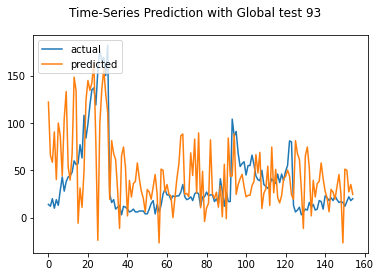

Restoring model weights from the end of the best epoch.
Epoch 00033: early stopping
Test MAPE: 188.536
Test sMAPE: 91.188
Test RMSE: 41.258
{'mape': 188.53606590816366, 'smape': 91.18791592923182, 'rmse': 41.257689551094785}


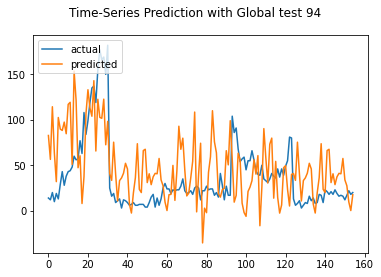

Test MAPE: 272.611
Test sMAPE: 99.647
Test RMSE: 52.016
{'mape': 272.61081848534485, 'smape': 99.64690479841937, 'rmse': 52.01617140658903}


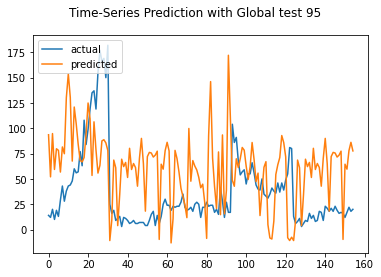

Restoring model weights from the end of the best epoch.
Epoch 00048: early stopping
Test MAPE: 196.252
Test sMAPE: 78.349
Test RMSE: 36.630
{'mape': 196.25160507356242, 'smape': 78.34860760488624, 'rmse': 36.62992959727383}


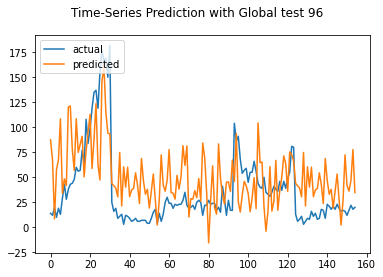

Restoring model weights from the end of the best epoch.
Epoch 00025: early stopping
Test MAPE: 192.422
Test sMAPE: 80.386
Test RMSE: 42.534
{'mape': 192.42173799760718, 'smape': 80.38596644947614, 'rmse': 42.53445235609508}


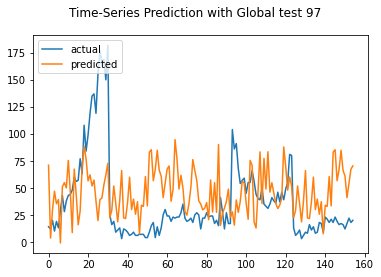

Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Test MAPE: 178.760
Test sMAPE: 90.286
Test RMSE: 41.676
{'mape': 178.7598118568582, 'smape': 90.28634837709244, 'rmse': 41.6760981111378}


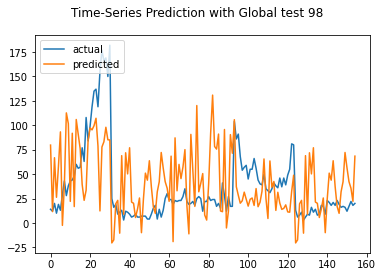

Restoring model weights from the end of the best epoch.
Epoch 00045: early stopping
Test MAPE: 216.937
Test sMAPE: 82.722
Test RMSE: 42.674
{'mape': 216.93707574847818, 'smape': 82.72207654445903, 'rmse': 42.673994530983904}


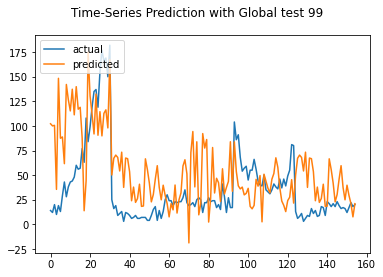

rmse : average=47.446, std=10.723
mape : average=213.618, std=54.416
smape : average=94.378, std=12.186


([47.44634202110062, 10.72285219839683],
 [213.61801799501222, 54.41557979498203],
 [94.37829271719544, 12.186223266866076])

In [13]:
# Use the Function:
sequence=train_X.shape[1]
features=train_X.shape[2]

calculate_mean_std(lstm_layers, nn_layers, sequence, features, dense_acivation, recurrent_cells, bidirectional, train_X, train_y, test_X, test_y, scalers['scaler_Labels'], monitor=True, plot=None, epochs=50, batch_size=16, n_tests=100, plot_samples=True, Municipality='Global')
